# 🔧 Data Preprocessing - E-Commerce Clothing Classifier

## Objective:
Prepare the dataset for training by:
1. Extracting dominant clothing category from segmentation masks
2. Creating labels for our 9 main categories
3. Resizing images to 224×224 pixels
4. Splitting data into train/validation/test sets (70/15/15)
5. Saving preprocessed data

---

**This notebook will take some time to run due to image processing!**

## Step 1: Install Required Package (tqdm)

In [1]:
# Install tqdm for progress bars
!pip install tqdm

print("✅ tqdm installed successfully!")

✅ tqdm installed successfully!


## Step 2: Import Libraries

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import json
from pathlib import Path
from collections import Counter
from tqdm import tqdm
import pickle
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## Step 3: Set Paths and Configuration

In [5]:
# Dataset paths
DATASET_ROOT = r"C:\Users\My PC\Documents\clothing_classifier\dataset"
IMAGES_PATH = os.path.join(DATASET_ROOT, "images")
SEGM_PATH = os.path.join(DATASET_ROOT, "segm")
CAPTIONS_FILE = os.path.join(DATASET_ROOT, "captions.json")

# Output paths
PROJECT_ROOT = r"C:\Users\My PC\Documents\clothing_classifier"
PROCESSED_DATA_PATH = os.path.join(PROJECT_ROOT, "data_processed")
os.makedirs(PROCESSED_DATA_PATH, exist_ok=True)

# Model configuration
IMAGE_SIZE = (224, 224)  # Standard size for transfer learning models
TRAIN_SPLIT = 0.70
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15

print("=" * 70)
print("CONFIGURATION")
print("=" * 70)
print(f"Dataset Root    : {DATASET_ROOT}")
print(f"Processed Data  : {PROCESSED_DATA_PATH}")
print(f"Target Image Size: {IMAGE_SIZE}")
print(f"Data Split      : Train={TRAIN_SPLIT}, Val={VAL_SPLIT}, Test={TEST_SPLIT}")
print("=" * 70)

CONFIGURATION
Dataset Root    : C:\Users\My PC\Documents\clothing_classifier\dataset
Processed Data  : C:\Users\My PC\Documents\clothing_classifier\data_processed
Target Image Size: (224, 224)
Data Split      : Train=0.7, Val=0.15, Test=0.15


## Step 4: Define Clothing Categories

In [7]:
# All 24 categories from segmentation
ALL_CATEGORIES = {
    0: 'background', 1: 'top', 2: 'outer', 3: 'skirt',
    4: 'dress', 5: 'pants', 6: 'leggings', 7: 'headwear',
    8: 'eyeglass', 9: 'neckwear', 10: 'belt', 11: 'footwear',
    12: 'bag', 13: 'hair', 14: 'face', 15: 'skin',
    16: 'ring', 17: 'wrist wearing', 18: 'socks', 19: 'gloves',
    20: 'necklace', 21: 'rompers', 22: 'earrings', 23: 'tie'
}

# Main clothing categories for classification (excluding body parts and accessories)
MAIN_CATEGORIES = {
    1: 'top',
    2: 'outer',
    3: 'skirt',
    4: 'dress',
    5: 'pants',
    6: 'leggings',
    11: 'footwear',
    12: 'bag',
    21: 'rompers'
}

# Create category name to index mapping for model
CATEGORY_TO_INDEX = {name: idx for idx, name in enumerate(MAIN_CATEGORIES.values())}
INDEX_TO_CATEGORY = {idx: name for name, idx in CATEGORY_TO_INDEX.items()}

NUM_CLASSES = len(MAIN_CATEGORIES)

print("\n📊 Classification Categories:")
print("=" * 70)
for idx, name in INDEX_TO_CATEGORY.items():
    print(f"  {idx}: {name.upper()}")
print("=" * 70)
print(f"\nTotal number of classes: {NUM_CLASSES}")


📊 Classification Categories:
  0: TOP
  1: OUTER
  2: SKIRT
  3: DRESS
  4: PANTS
  5: LEGGINGS
  6: FOOTWEAR
  7: BAG
  8: ROMPERS

Total number of classes: 9


## Step 5: Load Image-Segmentation Pairs

In [9]:
# Get all image files
image_files = sorted([f for f in os.listdir(IMAGES_PATH) 
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

# Get all segmentation files
segm_files = sorted(os.listdir(SEGM_PATH))

# Create mapping
segm_mapping = {}
for img_file in image_files:
    img_base = os.path.splitext(img_file)[0]
    expected_segm = img_base + "_segm.png"
    if expected_segm in segm_files:
        segm_mapping[img_file] = expected_segm

print(f"\n📊 Dataset Statistics:")
print("=" * 70)
print(f"Total images: {len(image_files):,}")
print(f"Images with segmentation: {len(segm_mapping):,}")
print(f"Coverage: {len(segm_mapping)/len(image_files)*100:.1f}%")
print("=" * 70)


📊 Dataset Statistics:
Total images: 44,096
Images with segmentation: 12,701
Coverage: 28.8%


## Step 6: Extract Dominant Category from Segmentation

For each image, we'll identify the **dominant clothing category** based on pixel count in the segmentation mask.

In [11]:
def get_dominant_category(segm_path):
    """
    Extract the dominant clothing category from segmentation mask.
    Returns category name and pixel count.
    """
    try:
        # Load segmentation mask
        seg = Image.open(segm_path)
        seg_array = np.array(seg)
        
        # Count pixels for each category
        unique, counts = np.unique(seg_array, return_counts=True)
        category_counts = dict(zip(unique, counts))
        
        # Find dominant main category (excluding background and body parts)
        main_cat_counts = {}
        for label_id, count in category_counts.items():
            if label_id in MAIN_CATEGORIES:
                category_name = MAIN_CATEGORIES[label_id]
                main_cat_counts[category_name] = count
        
        # Return dominant category
        if main_cat_counts:
            dominant_cat = max(main_cat_counts, key=main_cat_counts.get)
            pixel_count = main_cat_counts[dominant_cat]
            return dominant_cat, pixel_count
        else:
            return None, 0
            
    except Exception as e:
        print(f"Error processing {segm_path}: {e}")
        return None, 0

# Test on a few samples
print("\n🔍 Testing category extraction on sample images:\n")
for i, (img_name, segm_name) in enumerate(list(segm_mapping.items())[:5]):
    segm_path = os.path.join(SEGM_PATH, segm_name)
    category, pixels = get_dominant_category(segm_path)
    print(f"{i+1}. {img_name[:50]}...")
    print(f"   Dominant category: {category} ({pixels:,} pixels)\n")


🔍 Testing category extraction on sample images:

1. MEN-Denim-id_00000080-01_7_additional.jpg...
   Dominant category: top (75,768 pixels)

2. MEN-Denim-id_00000089-01_7_additional.jpg...
   Dominant category: pants (61,246 pixels)

3. MEN-Denim-id_00000089-02_7_additional.jpg...
   Dominant category: top (110,684 pixels)

4. MEN-Denim-id_00000089-03_7_additional.jpg...
   Dominant category: top (84,134 pixels)

5. MEN-Denim-id_00000089-04_7_additional.jpg...
   Dominant category: top (108,844 pixels)



## Step 7: Create Dataset with Labels

In [13]:
print("\n🔄 Extracting labels from all segmentation masks...\n")
print("This may take a few minutes...\n")

dataset = []
failed = 0

for img_name, segm_name in tqdm(segm_mapping.items(), desc="Processing"):
    segm_path = os.path.join(SEGM_PATH, segm_name)
    category, pixels = get_dominant_category(segm_path)
    
    if category and pixels > 0:
        dataset.append({
            'image_name': img_name,
            'segm_name': segm_name,
            'category': category,
            'category_index': CATEGORY_TO_INDEX[category],
            'pixel_count': pixels
        })
    else:
        failed += 1

# Create DataFrame
df = pd.DataFrame(dataset)

print(f"\n✅ Processing complete!")
print(f"   Successfully labeled: {len(df):,} images")
print(f"   Failed: {failed} images")
print(f"\nDataFrame shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())


🔄 Extracting labels from all segmentation masks...

This may take a few minutes...



Processing: 100%|██████████| 12701/12701 [10:46<00:00, 19.66it/s]



✅ Processing complete!
   Successfully labeled: 12,701 images
   Failed: 0 images

DataFrame shape: (12701, 5)

First few rows:
                                  image_name  \
0  MEN-Denim-id_00000080-01_7_additional.jpg   
1  MEN-Denim-id_00000089-01_7_additional.jpg   
2  MEN-Denim-id_00000089-02_7_additional.jpg   
3  MEN-Denim-id_00000089-03_7_additional.jpg   
4  MEN-Denim-id_00000089-04_7_additional.jpg   

                                        segm_name category  category_index  \
0  MEN-Denim-id_00000080-01_7_additional_segm.png      top               0   
1  MEN-Denim-id_00000089-01_7_additional_segm.png    pants               4   
2  MEN-Denim-id_00000089-02_7_additional_segm.png      top               0   
3  MEN-Denim-id_00000089-03_7_additional_segm.png      top               0   
4  MEN-Denim-id_00000089-04_7_additional_segm.png      top               0   

   pixel_count  
0        75768  
1        61246  
2       110684  
3        84134  
4       108844  


## Step 8: Analyze Category Distribution


📊 Category Distribution:
top            : 3,786 images (29.81%)
pants          : 3,049 images (24.01%)
dress          : 2,682 images (21.12%)
outer          : 1,835 images (14.45%)
rompers        :   721 images ( 5.68%)
skirt          :   583 images ( 4.59%)
bag            :    22 images ( 0.17%)
leggings       :    13 images ( 0.10%)
footwear       :    10 images ( 0.08%)
Total: 12,701 images



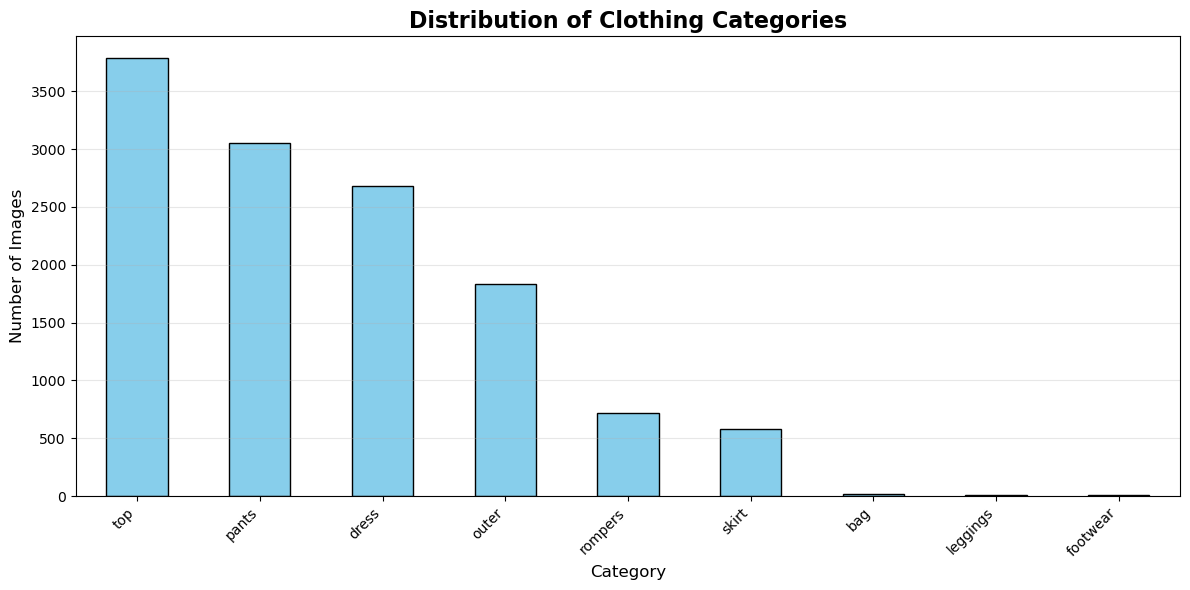


⚖️ Class Balance Analysis:
   Largest class: top (3,786 images)
   Smallest class: footwear (10 images)
   Imbalance ratio: 378.60:1
   ⚠️ Significant class imbalance detected!
   Consider using class weights during training.


In [15]:
# Count images per category
category_counts = df['category'].value_counts()

print("\n📊 Category Distribution:")
print("=" * 70)
for category, count in category_counts.items():
    percentage = (count / len(df)) * 100
    print(f"{category:15s}: {count:5,} images ({percentage:5.2f}%)")
print("=" * 70)
print(f"Total: {len(df):,} images\n")

# Visualize distribution
plt.figure(figsize=(12, 6))
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Clothing Categories', fontsize=16, fontweight='bold')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Check for class imbalance
min_count = category_counts.min()
max_count = category_counts.max()
imbalance_ratio = max_count / min_count

print(f"\n⚖️ Class Balance Analysis:")
print(f"   Largest class: {category_counts.idxmax()} ({max_count:,} images)")
print(f"   Smallest class: {category_counts.idxmin()} ({min_count:,} images)")
print(f"   Imbalance ratio: {imbalance_ratio:.2f}:1")

if imbalance_ratio > 3:
    print("   ⚠️ Significant class imbalance detected!")
    print("   Consider using class weights during training.")
else:
    print("   ✅ Classes are reasonably balanced.")

## Step 9: Split Data into Train/Val/Test Sets

In [17]:
# First split: separate test set (15%)
train_val_df, test_df = train_test_split(
    df, 
    test_size=TEST_SPLIT, 
    random_state=42, 
    stratify=df['category']  # Maintain category distribution
)

# Second split: separate validation from training
# VAL_SPLIT / (TRAIN_SPLIT + VAL_SPLIT) to get correct proportions
val_ratio = VAL_SPLIT / (TRAIN_SPLIT + VAL_SPLIT)
train_df, val_df = train_test_split(
    train_val_df,
    test_size=val_ratio,
    random_state=42,
    stratify=train_val_df['category']
)

print("\n📊 Data Split Summary:")
print("=" * 70)
print(f"Training set  : {len(train_df):,} images ({len(train_df)/len(df)*100:.1f}%)")
print(f"Validation set: {len(val_df):,} images ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test set      : {len(test_df):,} images ({len(test_df)/len(df)*100:.1f}%)")
print(f"Total         : {len(df):,} images")
print("=" * 70)

# Verify category distribution in each split
print("\n📋 Category Distribution in Each Split:\n")

splits_comparison = pd.DataFrame({
    'Train': train_df['category'].value_counts(),
    'Val': val_df['category'].value_counts(),
    'Test': test_df['category'].value_counts()
}).fillna(0).astype(int)

print(splits_comparison)
print("\n✅ Splits created with stratification to maintain category balance!")


📊 Data Split Summary:
Training set  : 8,889 images (70.0%)
Validation set: 1,906 images (15.0%)
Test set      : 1,906 images (15.0%)
Total         : 12,701 images

📋 Category Distribution in Each Split:

          Train  Val  Test
category                  
top        2650  568   568
pants      2133  458   458
dress      1877  403   402
outer      1284  276   275
rompers     505  108   108
skirt       408   87    88
bag          16    3     3
leggings      9    2     2
footwear      7    1     2

✅ Splits created with stratification to maintain category balance!


## Step 10: Save Processed Data

We'll save:
1. Train/Val/Test DataFrames
2. Category mappings
3. Configuration info

In [19]:
# Save train/val/test DataFrames
train_df.to_csv(os.path.join(PROCESSED_DATA_PATH, 'train_data.csv'), index=False)
val_df.to_csv(os.path.join(PROCESSED_DATA_PATH, 'val_data.csv'), index=False)
test_df.to_csv(os.path.join(PROCESSED_DATA_PATH, 'test_data.csv'), index=False)

# Save complete dataset
df.to_csv(os.path.join(PROCESSED_DATA_PATH, 'complete_dataset.csv'), index=False)

# Save category mappings
mappings = {
    'category_to_index': CATEGORY_TO_INDEX,
    'index_to_category': INDEX_TO_CATEGORY,
    'num_classes': NUM_CLASSES,
    'main_categories': MAIN_CATEGORIES,
    'image_size': IMAGE_SIZE
}

with open(os.path.join(PROCESSED_DATA_PATH, 'category_mappings.pkl'), 'wb') as f:
    pickle.dump(mappings, f)

# Save configuration
config = {
    'dataset_root': DATASET_ROOT,
    'image_size': IMAGE_SIZE,
    'train_split': TRAIN_SPLIT,
    'val_split': VAL_SPLIT,
    'test_split': TEST_SPLIT,
    'num_classes': NUM_CLASSES,
    'total_images': len(df),
    'train_images': len(train_df),
    'val_images': len(val_df),
    'test_images': len(test_df)
}

with open(os.path.join(PROCESSED_DATA_PATH, 'config.json'), 'w') as f:
    json.dump(config, f, indent=4)

print("\n💾 Saved Files:")
print("=" * 70)
print("  ✅ train_data.csv")
print("  ✅ val_data.csv")
print("  ✅ test_data.csv")
print("  ✅ complete_dataset.csv")
print("  ✅ category_mappings.pkl")
print("  ✅ config.json")
print("=" * 70)
print(f"\nAll files saved to: {PROCESSED_DATA_PATH}")


💾 Saved Files:
  ✅ train_data.csv
  ✅ val_data.csv
  ✅ test_data.csv
  ✅ complete_dataset.csv
  ✅ category_mappings.pkl
  ✅ config.json

All files saved to: C:\Users\My PC\Documents\clothing_classifier\data_processed


## Step 11: Visualize Sample Images with Labels


🖼️ Visualizing labeled samples from each split:

Training Set:


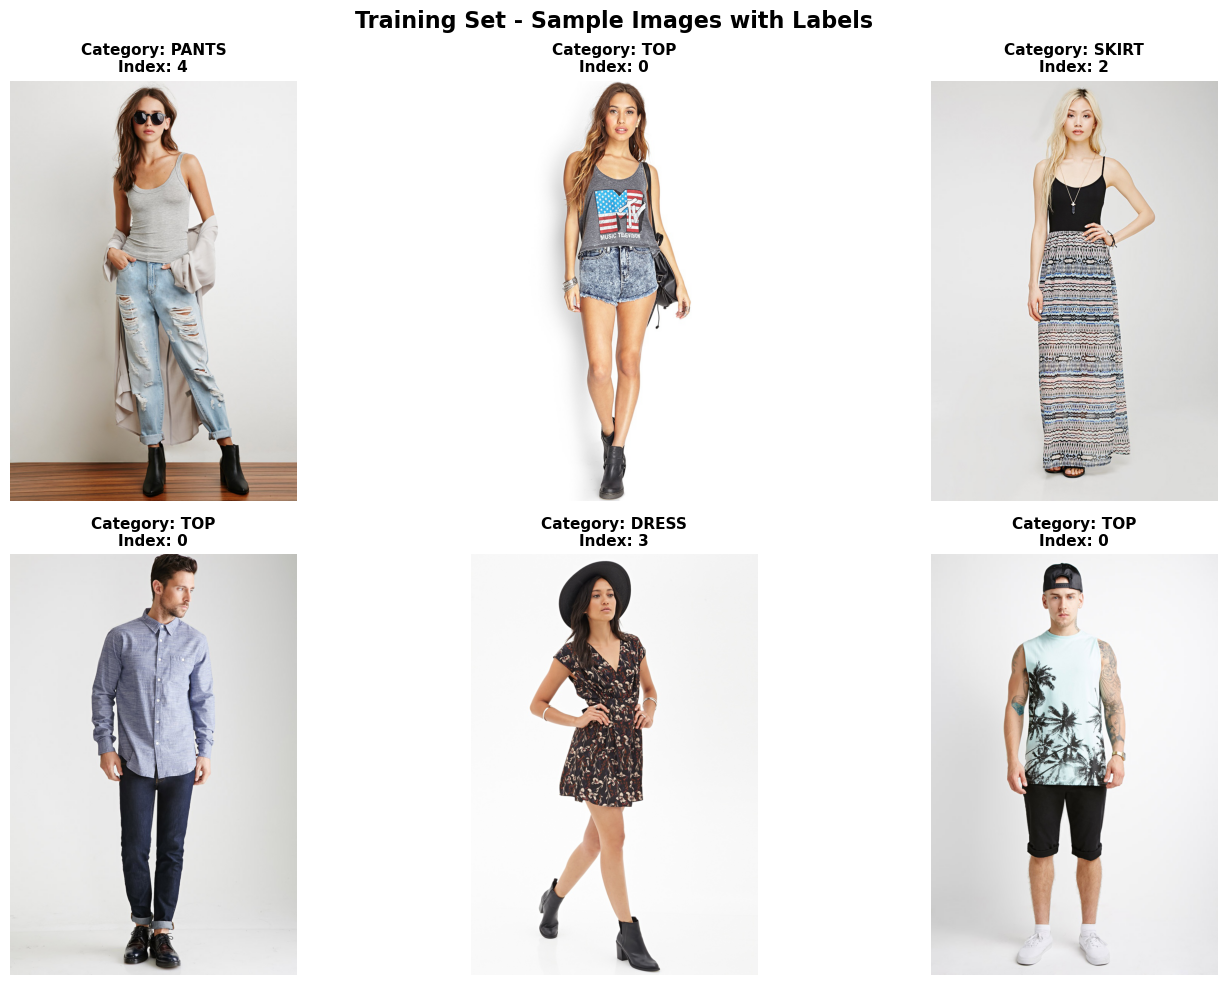


Validation Set:


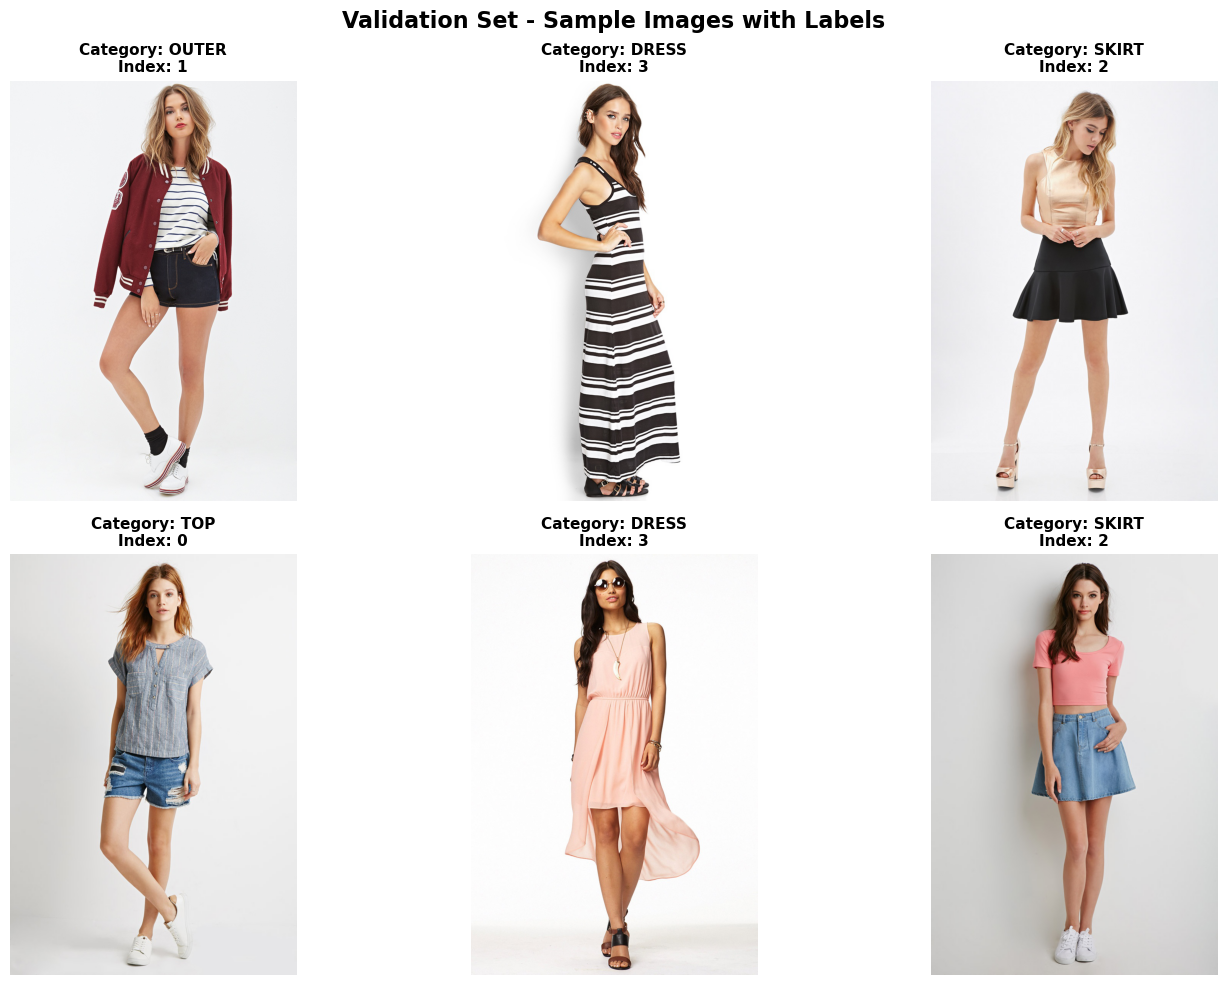


Test Set:


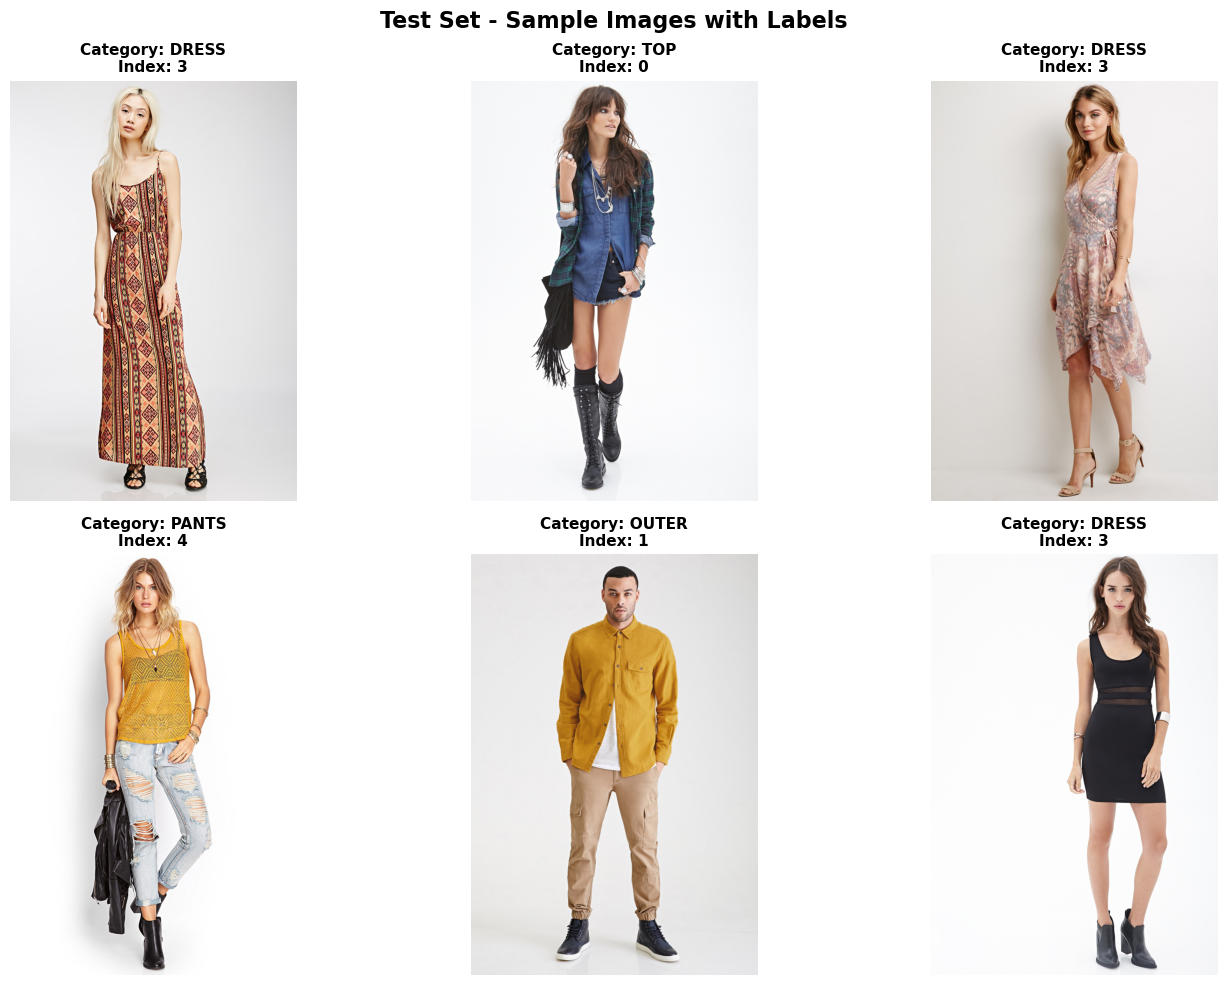

In [21]:
def visualize_samples_with_labels(df, num_samples=6, split_name="Train"):
    """Visualize random samples with their predicted labels"""
    
    samples = df.sample(n=min(num_samples, len(df)))
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, (_, row) in enumerate(samples.iterrows()):
        if idx >= len(axes):
            break
            
        img_path = os.path.join(IMAGES_PATH, row['image_name'])
        
        try:
            img = Image.open(img_path)
            axes[idx].imshow(img)
            
            title = f"Category: {row['category'].upper()}\nIndex: {row['category_index']}"
            axes[idx].set_title(title, fontsize=11, fontweight='bold')
            axes[idx].axis('off')
            
        except Exception as e:
            axes[idx].text(0.5, 0.5, f"Error\n{str(e)[:30]}", 
                          ha='center', va='center')
            axes[idx].axis('off')
    
    plt.suptitle(f'{split_name} Set - Sample Images with Labels', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Visualize samples from each split
print("\n🖼️ Visualizing labeled samples from each split:\n")

print("Training Set:")
visualize_samples_with_labels(train_df, num_samples=6, split_name="Training")

print("\nValidation Set:")
visualize_samples_with_labels(val_df, num_samples=6, split_name="Validation")

print("\nTest Set:")
visualize_samples_with_labels(test_df, num_samples=6, split_name="Test")

## 📊 Preprocessing Summary

In [23]:
print("\n" + "=" * 70)
print("DATA PREPROCESSING COMPLETE!")
print("=" * 70)

summary = f"""
✅ Successfully processed {len(df):,} images
✅ Extracted labels from segmentation masks
✅ Created {NUM_CLASSES} clothing categories
✅ Split data: Train ({len(train_df):,}) / Val ({len(val_df):,}) / Test ({len(test_df):,})
✅ Saved processed data to: {PROCESSED_DATA_PATH}

📋 Category Distribution:
"""

print(summary)

for category, count in category_counts.items():
    print(f"   {category:15s}: {count:5,} images")

print("\n" + "=" * 70)
print("\n🚀 READY FOR MODEL BUILDING AND TRAINING!")
print("\nNext steps:")
print("  1. Build CNN model with transfer learning")
print("  2. Set up data generators with augmentation")
print("  3. Train the model")
print("  4. Evaluate performance")
print("  5. Create demo for presentation")
print("\n" + "=" * 70)


DATA PREPROCESSING COMPLETE!

✅ Successfully processed 12,701 images
✅ Extracted labels from segmentation masks
✅ Created 9 clothing categories
✅ Split data: Train (8,889) / Val (1,906) / Test (1,906)
✅ Saved processed data to: C:\Users\My PC\Documents\clothing_classifier\data_processed

📋 Category Distribution:

   top            : 3,786 images
   pants          : 3,049 images
   dress          : 2,682 images
   outer          : 1,835 images
   rompers        :   721 images
   skirt          :   583 images
   bag            :    22 images
   leggings       :    13 images
   footwear       :    10 images


🚀 READY FOR MODEL BUILDING AND TRAINING!

Next steps:
  1. Build CNN model with transfer learning
  2. Set up data generators with augmentation
  3. Train the model
  4. Evaluate performance
  5. Create demo for presentation

